Herramientas utilizadas: Pandas y matplotlib

Número de vuelos filtrados por la fecha de vuelo y destino

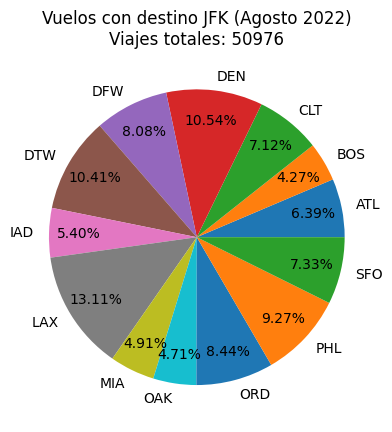

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Leo el dataframe
df = pd.read_csv('itineraries_clean.csv')
df = df[['legId', 'startingAirport', 'destinationAirport', 'flightDate']]

# Me quedo con los vuelos únicos, evito repeticiones del mismo vuelo
df = df.drop_duplicates(subset=['legId'])

# Convierto a objeto datetime para poder filtrar bien
df['flightDate'] = pd.to_datetime(df['flightDate'])
start_date = pd.Timestamp('2022-08-01')  # Fecha de inicio
end_date = pd.Timestamp('2022-08-31')  # Fecha de fin

# Me quedo con los vuelos dentro del rango de fechas y que se dirijan a un destino especifico
df = df.loc[((df['flightDate'] >= start_date) & (df['flightDate'] <= end_date)) & (df['destinationAirport'] == 'JFK')] 

df = df[['startingAirport', 'destinationAirport']]
df = df.groupby(['startingAirport', 'destinationAirport']).size().reset_index(name='Count')

viajesTotales = df['Count'].sum()

# Genero el gráfico circular
plt.pie(df['Count'], labels=df['startingAirport'], autopct='%0.2f%%', pctdistance=0.8)
plt.title(f'Vuelos con destino JFK (Agosto 2022)\nViajes totales: {viajesTotales}')
plt.show()

#plt.savefig('vuelosJFK.png', bbox_inches='tight')

Número de búsquedas de vuelos por mes

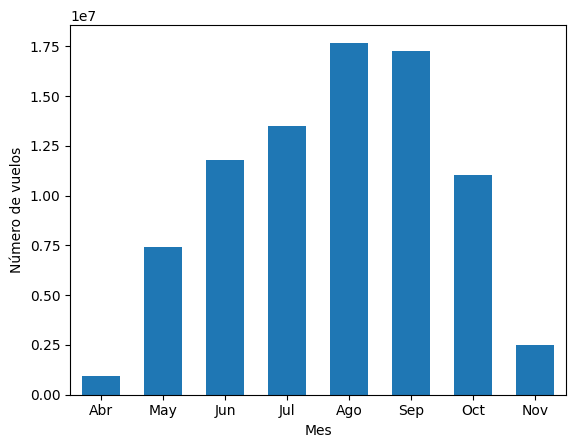

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Leo el dataframe
df = pd.read_csv('itineraries_clean.csv')
df = df[['legId', 'startingAirport', 'destinationAirport', 'flightDate']]

# Convierto a objeto datetime para poder sacar el mes del vuelo
df['flightDate'] = pd.to_datetime(df['flightDate'])
df['month'] = df['flightDate'].dt.month

# Consigo una serie que contiene el mes y el número de vuelos
flight_count = df['month'].value_counts().sort_index()

# Creo un gráfico de barras
fig, ax = plt.subplots()
ax.bar(flight_count.index, flight_count.values, align='center', width=0.6)

# Ajustes del gráfico
ax.set_xlabel('Mes')
ax.set_ylabel('Número de vuelos')
ax.set_xticks(range(4, 12))
ax.set_xticklabels(['Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov'], ha='center')
ax.set_xlim(3.5, 11.5)

plt.show()

# plt.savefig('busquedasXMes.png')

Número de vuelos por aeropuerto de destino (Abril - Noviembre)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Leo el dataframe
df = pd.read_csv('itineraries_clean.csv')
df = df[['legId', 'startingAirport', 'destinationAirport']]

# Me quedo con los vuelos únicos, evito repeticiones del mismo vuelo
df = df.drop_duplicates(subset=['legId'])

#Me quedo con los vuelos que se dirijan a un destino especifico
df = df.loc[(df['destinationAirport'] == 'JFK')]

df = df.groupby(['startingAirport', 'destinationAirport']).size().reset_index(name='Count')

viajesTotales = df['Count'].sum()

# Genero gráfico circular
plt.pie(df['Count'], labels=df['startingAirport'], autopct='%0.2f%%')
plt.title(f'Vuelos con destino JFK \nViajes totales: {viajesTotales}')
plt.show()

# plt.savefig('vuelosJFK(anyoEntero).png', bbox_inches='tight')

Número de vuelos según el tipo de tarifa y origen

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('itineraries_clean.csv')

# Me quedo con los vuelos únicos, evito repeticiones del mismo vuelo
df = df.drop_duplicates(subset=['legId'])

# Me quedo con los vuelos con origen ATL
df = df.loc[(df['startingAirport'] == 'ATL')]
df = df.groupby(['startingAirport', 'destinationAirport', 'isBasicEconomy']).size().reset_index(name='Count')
df = df.sort_values(by='Count')

label = np.where(df['isBasicEconomy'], '(basic)', '(not basic)')

# Creo gráfico de barras
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(df['destinationAirport'] + label, df['Count'])

# Configuro el gráfico
ax.set_title('Número de vuelos según tipo de tarifa y origen', fontsize=16)
ax.set_xlabel('Aeropuerto de destino', fontsize=14)
ax.set_ylabel('Número de vuelos', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

# plt.savefig('vuelosEconomiaBasica(ATL).png', dpi=300, bbox_inches='tight')

Herramientas utilizadas: Spark

Gráfico de barras de los vuelos ofrecidos por cada aerolínea

In [3]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Creo una sesión de Spark
spark = SparkSession.builder.appName('numAerolineas').getOrCreate()

# Leo el csv y creo el DataFrame
df = spark.read.option("header", True).csv("itineraries_clean.csv")

# Borro las búsquedas duplicadas
df = df.dropDuplicates(['legId'])

# Selecciono la columna de aerolíneas y separarlas por "||" si hay varias en una misma fila
rdd = df.rdd.flatMap(lambda x: x['segmentsAirlineName'].split('||'))

# Apariciones de cada aerolínea
rdd = rdd.map(lambda x: (x.strip(), 1)).reduceByKey(lambda a, b: a + b)

# Creo el DataFrame de pandas y ordenarlo de mayor a menor
df_pandas = rdd.toDF(['aerolinea', 'count']).sort('count', ascending=False).toPandas()

# Creo el gráfico de barras horizontales y hago los ajustes necesarios
plt.barh(df_pandas['aerolinea'], df_pandas['count'])
plt.title('Conteo de aerolíneas')
plt.xlabel('Conteo')
plt.ylabel('Aerolínea')
plt.xscale('log')
plt.show()

# plt.savefig('grafico_aerolineas.png', bbox_inches='tight')